# 2024/03/23 mnist num으로 CNN 모델 만들기

In [27]:
### ===> Module Import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

torch.manual_seed(42)

In [7]:
### ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.0  Device: cpu


In [240]:
### ===>  데이터 추출 관련 변수
BATCH_SIZE = 50
EPOCHS = 10

transforms
- Resize: 이미지의 크기를 조절합니다.
- RandomResizedCrop: 이미지를 무작위로 자르고 크기를 조절합니다.
- RandomHorizontalFlip: 이미지를 무작위로 수평으로 뒤집습니다.
- RandomVerticalFlip: 이미지를 무작위로 수직으로 뒤집습니다.
- ToTensor: 이미지를 텐서로 변환합니다.!!!!!!!!!!!!!!!!!!!!!!!
- Normalize: 이미지를 정규화합니다.!!!!!!!!!!!!!!!!!!!!!!!!!!
- ColorJitter: 이미지의 색상을 무작위로 조정합니다.
- RandomRotation: 이미지를 무작위로 회전합니다.
- RandomCrop: 이미지를 무작위로 자릅니다.
- Grayscale: 이미지를 흑백으로 변환합니다.
- RandomSizedCrop: 이미지를 무작위로 자르고 크기를 조절합니다.

In [241]:
### ===> CIFAR10 데이터 다운로드 (Train set, Test set 분리하기)
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Lambda(lambda x: x/255.0)])

train_dataset = datasets.MNIST(root = "../data/MNIST_NUM",
                                  train = True,
                                  download = True,
                                  transform = transform)

test_dataset = datasets.MNIST(root = "../data/MNIST_NUM",
                                train = False,
                                transform = transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

train_loader/255

In [242]:
len(train_loader)

1200

In [243]:
# 데이터 확인하기

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break # 한 배치만 알아봐도 되니까 멈추도록

X_train: torch.Size([50, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([50]) type: torch.LongTensor


32, 1, 28, 28 => 저차원부터 생각하면
- __28__ row
- __28__ col 인 __네모__ 가
- 흑백이라서 __1__ channel로 __사진 하나__ 완성
- 근데 배치가 __32__ 라서 사진이 32장 있는 것!

In [244]:
X_train[0].shape # 텐서가 담고 있는 것은 channel, 

# - img -> 세로, 가로, RGB 
# - 파이토치 모듈 -> RGB, 세로, 가로 순으로 배치

# 즉 토치의 차원인덱스 기준 0, 1, 2를 사진으로 보고싶다면  
# 배치를 1, 2, 0으로 바꿔야함

torch.Size([1, 28, 28])

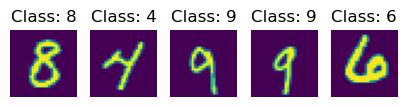

In [245]:
# 짝끼리 잘 맞는지 보자
pltsize = 1
image_num = 5 # 사진 몇장 볼래
plt.figure(figsize=(image_num * pltsize, pltsize))

for i in range(image_num):
    plt.subplot(1, image_num, i+1) # subplot index는 1부터!!
    plt.axis("off") # 눈금필요 없지예
    plt.imshow(X_train[i].permute(1, 2, 0)) # .permute(1, 2)
    plt.title('Class: ' + str(y_train[i].item())) # tensor라서 item 사용해야함 

# class 분배가 고른지 확인, 데이터 전처리

In [246]:
y_train.bincount() # 숫자의 순서대로 나오는 거임 0~9까지 
# 배치마다 좀 불균형할 수도 shuffle 때문인가

tensor([1, 4, 6, 6, 5, 4, 6, 6, 5, 7])

In [247]:
max = 20
for cnt, (_, y_train) in enumerate(train_loader):
    print(f'y_train 분포:{cnt}\n{y_train.bincount()}\n')
    if max < cnt:
        break

y_train 분포:0
tensor([5, 8, 6, 7, 3, 5, 7, 2, 2, 5])

y_train 분포:1
tensor([8, 8, 2, 5, 4, 4, 5, 6, 5, 3])

y_train 분포:2
tensor([ 8,  6,  7,  6,  2,  1,  3,  5, 10,  2])

y_train 분포:3
tensor([3, 3, 4, 5, 3, 6, 6, 5, 7, 8])

y_train 분포:4
tensor([5, 3, 7, 4, 5, 1, 8, 5, 6, 6])

y_train 분포:5
tensor([6, 9, 4, 6, 6, 6, 4, 3, 2, 4])

y_train 분포:6
tensor([7, 5, 1, 8, 2, 3, 5, 3, 9, 7])

y_train 분포:7
tensor([6, 8, 4, 8, 2, 6, 5, 3, 3, 5])

y_train 분포:8
tensor([3, 5, 7, 6, 6, 3, 4, 3, 8, 5])

y_train 분포:9
tensor([6, 9, 3, 7, 3, 5, 5, 2, 6, 4])

y_train 분포:10
tensor([7, 2, 5, 7, 7, 4, 3, 5, 4, 6])

y_train 분포:11
tensor([9, 1, 4, 7, 5, 1, 6, 5, 5, 7])

y_train 분포:12
tensor([ 7, 11,  3,  4,  2,  5,  5,  3,  6,  4])

y_train 분포:13
tensor([3, 3, 3, 9, 7, 6, 6, 5, 5, 3])

y_train 분포:14
tensor([6, 8, 3, 6, 4, 4, 6, 6, 3, 4])

y_train 분포:15
tensor([1, 5, 4, 9, 6, 3, 3, 8, 5, 6])

y_train 분포:16
tensor([6, 3, 7, 4, 9, 2, 6, 6, 4, 3])

y_train 분포:17
tensor([7, 8, 5, 7, 4, 7, 2, 4, 4, 2])

y_train 분포:18
tens

# 분포가 안맞지예... -> 배치에 최소한 1개씩은 있어야하지 않나...? ㅇㅅㅇ

In [248]:
'''
in_channel(int) : 입력 채널의 수, RGB의 경우 3, 현재는 1
out_channel(int) : 출력 채널의 개수, 컨볼루션 필터 개수
=> 1개의 필터는 무조건 3차원 
'''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # in rgb, 커널은 8개 준비고했고 사이즈는 3*3짜리얌
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, padding = 1) # 커널이 8개면 결과도 8개 
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        # 풀링을 줘서 줄임
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(7*7*16, 64) # 곱한 결과가 784가 되도록?????
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10) # 마지막 출력은 라벨의 개수인 10개 
        
    def forward(self, x):
        x = self.conv1(x) # 패딩이랑 커널사이즈 때문에 row, col의 크기는 변화 X => 28 28 8
        x = F.relu(x)
        x = self.pool(x) # pooling 때문에 반갈죽 => 14 14 8
        x = self.conv2(x) # 14 14 16
        x = F.relu(x)
        x = self.pool(x) # pooling 또 반갈죽 => 7 7 16
        
        x = x.view(-1, 7*7*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [249]:
######################################################
def make_weights_for_balanced_classes(y):
    y_bins=np.bincount(y)
    N=sum(y_bins)
    # print(y_bins)

    y_bins = y_bins.astype(float)/N
    y_bins[y_bins == np.inf] = 0   
    y_bins = 1-y_bins
    
    if len(y_bins) != 10:
        pad = 10 - len(y_bins)
        y_bins =np.hstack((y_bins, np.ones(pad)))
    
                               
    return y_bins

In [250]:
np.hstack(([2, 4, 6, 2, 6, 3, 3, 3, 2, 1], 0))

array([2, 4, 6, 2, 6, 3, 3, 3, 2, 1, 0])

In [251]:
######################################################
print(y_train.bincount())
print(make_weights_for_balanced_classes(y_train)) # 개수가 적은 애한테 가중치를 마니마니?

tensor([3, 6, 6, 5, 5, 9, 6, 4, 2, 4])
[0.94 0.88 0.88 0.9  0.9  0.82 0.88 0.92 0.96 0.92]


In [252]:
### ===> Optimizer, Objective Function 설정
model = CNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [253]:
### ===> CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        # ######################################################
        # weights = make_weights_for_balanced_classes(label)
        # class_weights = torch.FloatTensor(weights)
        # print(label)
        # print(class_weights)
        
        optimizer.zero_grad()
        output = model(image)
        # criterion = nn.CrossEntropyLoss(weight=class_weights)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")

In [254]:
### ===> 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 학습진행

In [255]:
### ===> CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for epoch in range(1, EPOCHS + 1):
    
    train(epoch, model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

Train Epoch: 1 [0]	Train Loss: 2.313880
Train Epoch: 1 [200]	Train Loss: 2.302053
Train Epoch: 1 [400]	Train Loss: 2.300368
Train Epoch: 1 [600]	Train Loss: 2.312224
Train Epoch: 1 [800]	Train Loss: 2.294971
Train Epoch: 1 [1000]	Train Loss: 2.318285

[EPOCH: 1], 	Test Loss: 0.0460, 	Test Accuracy: 11.35 % 

Train Epoch: 2 [0]	Train Loss: 2.305834
Train Epoch: 2 [200]	Train Loss: 2.320568
Train Epoch: 2 [400]	Train Loss: 2.304851
Train Epoch: 2 [600]	Train Loss: 1.742979
Train Epoch: 2 [800]	Train Loss: 0.983160
Train Epoch: 2 [1000]	Train Loss: 0.923037

[EPOCH: 2], 	Test Loss: 0.0151, 	Test Accuracy: 75.54 % 

Train Epoch: 3 [0]	Train Loss: 0.832959
Train Epoch: 3 [200]	Train Loss: 0.667302
Train Epoch: 3 [400]	Train Loss: 0.670909
Train Epoch: 3 [600]	Train Loss: 0.609467
Train Epoch: 3 [800]	Train Loss: 0.489177
Train Epoch: 3 [1000]	Train Loss: 0.388585

[EPOCH: 3], 	Test Loss: 0.0117, 	Test Accuracy: 81.47 % 

Train Epoch: 4 [0]	Train Loss: 0.535451
Train Epoch: 4 [200]	Train Los

# 예측




In [256]:
import cv2
import numpy as np

In [257]:
def print_img(num):
    my_num = cv2.imread(f'../data/my_num{num}.png', cv2.IMREAD_GRAYSCALE)
    
    my_num = cv2.resize(my_num, (28, 28))
    
    my_num = abs(my_num.astype("int") - 255) # 이미지는 흰부분이 255라서 
    
    # cv2.imshow("my_num", my_num.astype(np.uint8))
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    
    my_img = torch.FloatTensor(my_num/255)
    return my_img

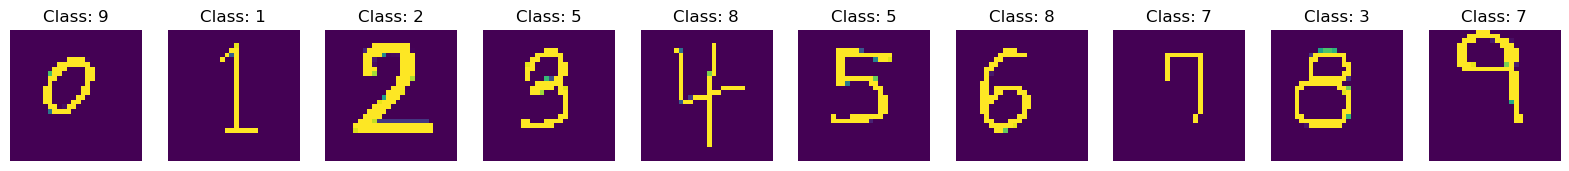

In [258]:
image_num = 10
pltsize = 2
plt.figure(figsize=(image_num * pltsize, pltsize))

for i in range(10):
    my_img = print_img(i)
    output = model(my_img.reshape(1, 28, 28))
    result = output.argmax().item()
    
    
    
    plt.subplot(1, image_num, i+1) # subplot index는 1부터!!
    plt.axis("off") # 눈금필요 없지예
    plt.imshow(my_img)
    plt.title('Class: ' + str(result)) # tensor라서 item 사용해야함 
    
#     
#     
# for i in range(image_num):
#     plt.subplot(1, image_num, i+1) # subplot index는 1부터!!
#     plt.axis("off") # 눈금필요 없지예
#     plt.imshow(X_train[i].permute(1, 2, 0)) # .permute(1, 2)
#     plt.title('Class: ' + str(y_train[i].item())) # tensor라서 item 사용해야함 

In [ ]:
# ㅙ 나한테만 각박한데